# Insurance Fraud Detection - EDA

This notebook performs exploratory data analysis on insurance claim data to identify patterns and insights for fraud detection.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost
import imblearn
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


%matplotlib inline



In [3]:
# Print version numbers
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("imblearn:", imblearn.__version__)

numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.9.2
seaborn: 0.13.2
scikit-learn: 1.5.1
xgboost: 3.0.2
imblearn: 0.12.3


In [4]:
# Load the dataset
df = pd.read_csv(r"D:\Capstone Project\insurance fraud claims.csv")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


## Basic Information and Cleanup

In [6]:
# Check basic info
df.info()

# Drop completely empty columns
df.drop(columns=['_c39'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

## Missing Values Analysis

In [8]:
# Check for missing values or placeholders
df.replace('?', np.nan, inplace=True)
missing = df.isnull().sum()
missing[missing > 0]

collision_type             178
authorities_contacted       91
property_damage            360
police_report_available    343
dtype: int64

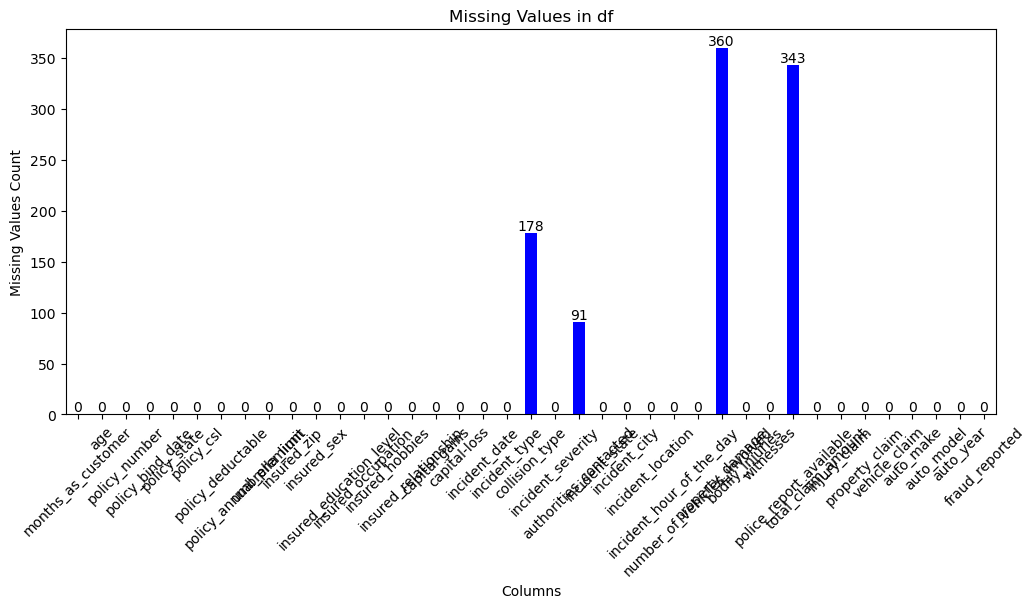

In [9]:

# Plot missing values as a bar chart
ax = df.isna().sum().plot(kind='bar', figsize=(12, 5), color='blue')

# Add data labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,  # X position
            p.get_height(),                 # Y position
            int(p.get_height()),            # Value to display
            ha='center', va='bottom',       # Center-align text
            fontsize=10, color='black')     # Styling

# Add labels and title
plt.xlabel("Columns")
plt.ylabel("Missing Values Count")
plt.title("Missing Values in df")
plt.xticks(rotation=45)  # Rotate x labels for readability

# Show plot
plt.show()

## Convert Date Columns

In [11]:
# Convert date columns
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])

## Summary Statistics

In [13]:
# Summary of numerical features
df.describe()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_date,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,2002-02-08 04:40:47.999999872,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,2015-01-30 08:02:24,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
min,0.000000,19.000000,100804.000000,1990-01-08 00:00:00,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,2015-01-01 00:00:00,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,1995-09-19 00:00:00,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,2015-01-15 00:00:00,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,2002-04-01 12:00:00,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,2015-01-31 00:00:00,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2008-04-21 12:00:00,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,2015-02-15 00:00:00,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2015-02-22 00:00:00,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,2015-03-01 00:00:00,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000
std,115.113174,9.140287,257063.005276,NaN,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,NaN,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861


## Categorical Value Counts

In [15]:
# Target distribution
print(df['fraud_reported'].value_counts())

# Show top value counts of some important categorical columns
categorical_cols = ['incident_type', 'collision_type', 'incident_severity', 'authorities_contacted']
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

fraud_reported
N    753
Y    247
Name: count, dtype: int64

Value counts for incident_type:
incident_type
Multi-vehicle Collision     419
Single Vehicle Collision    403
Vehicle Theft                94
Parked Car                   84
Name: count, dtype: int64

Value counts for collision_type:
collision_type
Rear Collision     292
Side Collision     276
Front Collision    254
Name: count, dtype: int64

Value counts for incident_severity:
incident_severity
Minor Damage      354
Total Loss        280
Major Damage      276
Trivial Damage     90
Name: count, dtype: int64

Value counts for authorities_contacted:
authorities_contacted
Police       292
Fire         223
Other        198
Ambulance    196
Name: count, dtype: int64


In [16]:
df.isna().count()

months_as_customer             1000
age                            1000
policy_number                  1000
policy_bind_date               1000
policy_state                   1000
policy_csl                     1000
policy_deductable              1000
policy_annual_premium          1000
umbrella_limit                 1000
insured_zip                    1000
insured_sex                    1000
insured_education_level        1000
insured_occupation             1000
insured_hobbies                1000
insured_relationship           1000
capital-gains                  1000
capital-loss                   1000
incident_date                  1000
incident_type                  1000
collision_type                 1000
incident_severity              1000
authorities_contacted          1000
incident_state                 1000
incident_city                  1000
incident_location              1000
incident_hour_of_the_day       1000
number_of_vehicles_involved    1000
property_damage             

In [17]:
df['authorities_contacted'].fillna('unknown', inplace=True)


C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\2903435027.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authorities_contacted'].fillna('unknown', inplace=True)


## Correlation Heatmap (Numerical Features)

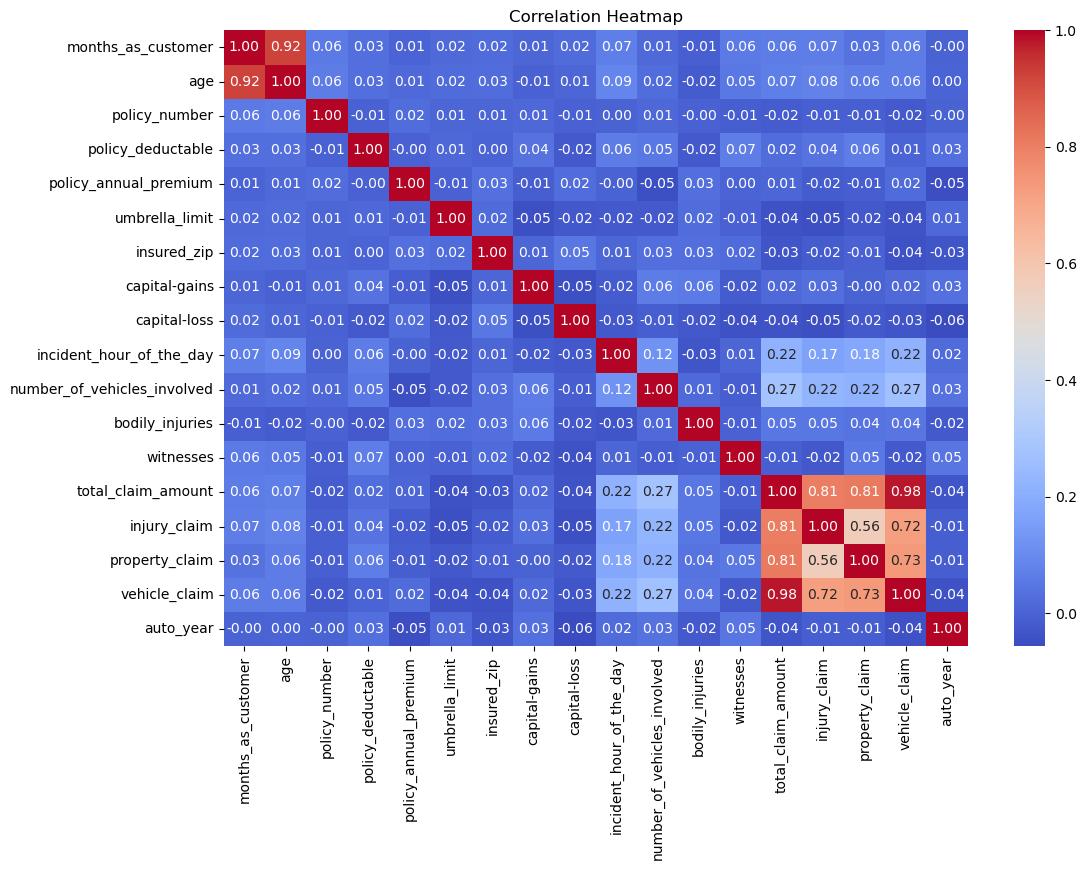

In [19]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Boxplots and Histograms

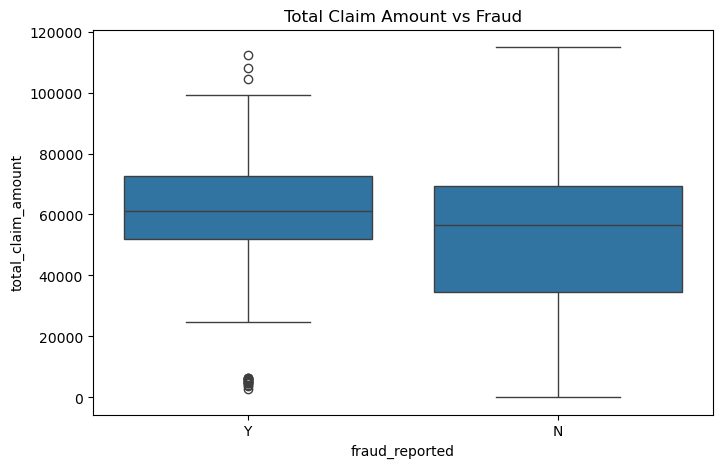

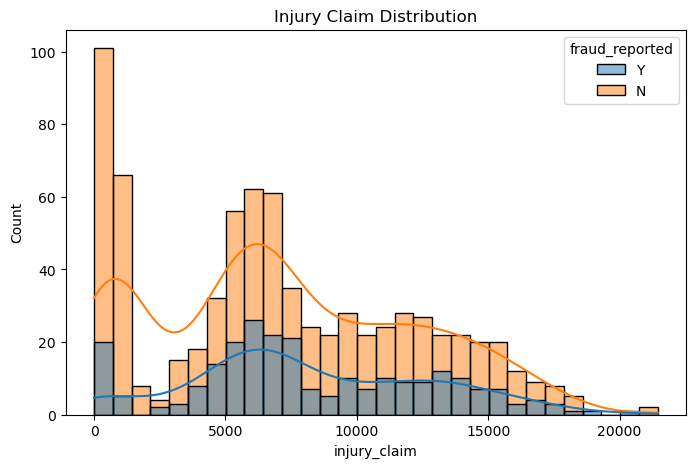

In [21]:
# Distribution of total_claim_amount by fraud
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='fraud_reported', y='total_claim_amount')
plt.title("Total Claim Amount vs Fraud")
plt.show()

# Distribution of injury_claim
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='injury_claim', hue='fraud_reported', kde=True, bins=30)
plt.title("Injury Claim Distribution")
plt.show()

## Fraud Distribution by Category

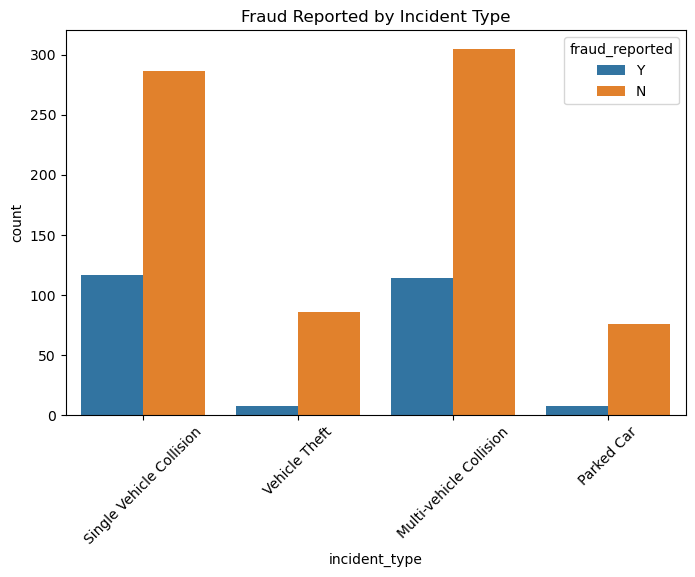

In [23]:
# Example of fraud rate by incident_type
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='incident_type', hue='fraud_reported')
plt.xticks(rotation=45)
plt.title("Fraud Reported by Incident Type")
plt.show()

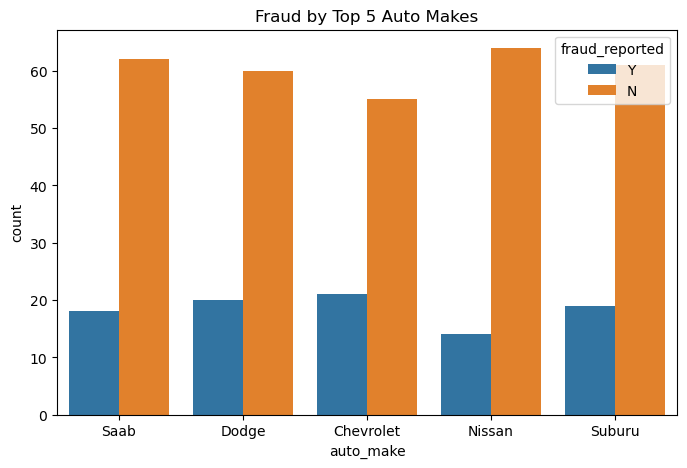

In [24]:
# Another example: vehicle_make
top_makes = df['auto_make'].value_counts().nlargest(5).index
subset = df[df['auto_make'].isin(top_makes)]

plt.figure(figsize=(8, 5))
sns.countplot(data=subset, x='auto_make', hue='fraud_reported')
plt.title("Fraud by Top 5 Auto Makes")
plt.show()

In [25]:
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,NaN,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,NaN,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,NaN,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


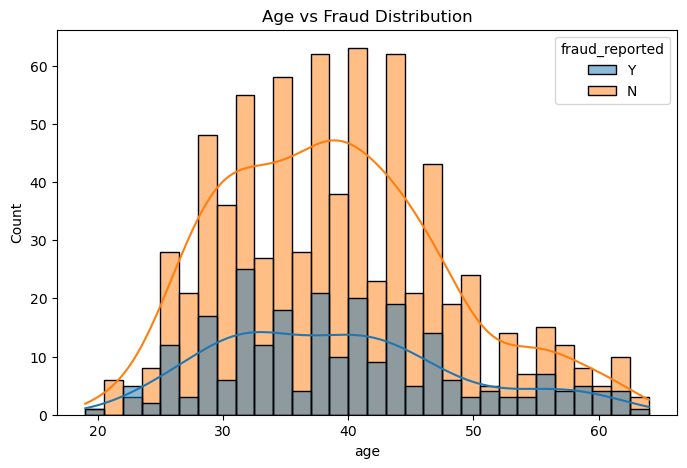

In [26]:
# Distribution of age vs fraud
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='age', hue='fraud_reported', kde=True, bins=30)
plt.title("Age vs Fraud Distribution")
plt.show()


In [27]:
# Impute missing categorical values
for i in ['collision_type', 'property_damage', 'police_report_available', 'authorities_contacted']:
    df[i].fillna('Unknown', inplace=True)

C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\1124841492.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna('Unknown', inplace=True)


In [28]:
# Calculate claim-to-premium ratio, handling potential division by zero
df['claim_premium_ratio'] = df['total_claim_amount'] / df['policy_annual_premium']
df['claim_premium_ratio'].replace([np.inf, -np.inf], 0, inplace=True) # Replace infinity with 0 or another suitable value

C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\3168342645.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['claim_premium_ratio'].replace([np.inf, -np.inf], 0, inplace=True) # Replace infinity with 0 or another suitable value


In [29]:
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,claim_premium_ratio
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,50.898778
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,Unknown,5070,780,780,3510,Mercedes,E400,2007,Y,4.234811
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,24.519864
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,44.782234
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,4.103769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,Unknown,87200,17440,8720,61040,Honda,Accord,2006,N,66.524260
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,Unknown,108480,18080,18080,72320,Volkswagen,Passat,2015,N,75.501639
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,48.789655
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,34.622527


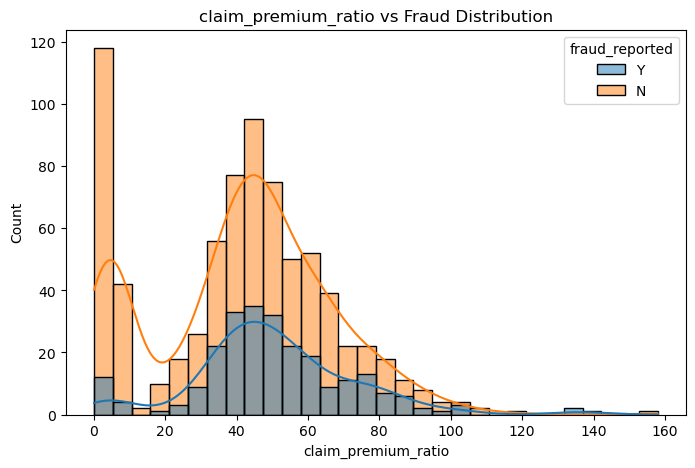

In [30]:
# Distribution of claim_premium_ratio
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='claim_premium_ratio', hue='fraud_reported', kde=True, bins=30)
plt.title("claim_premium_ratio vs Fraud Distribution")
plt.show()

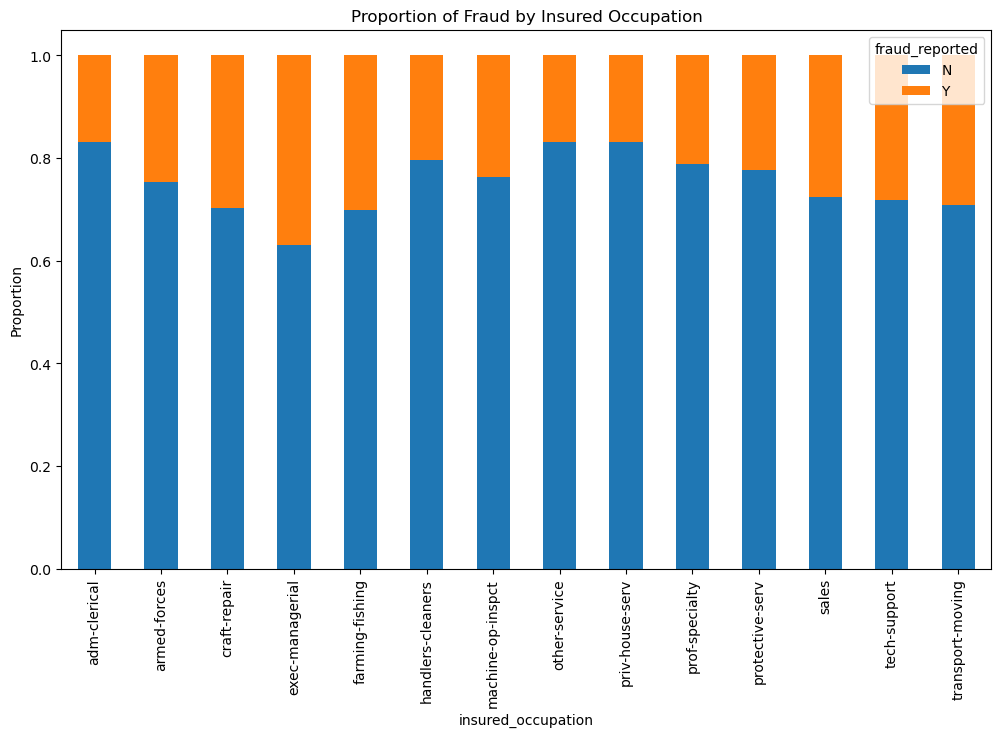

In [31]:
# Create a cross-tabulation of occupation and fraud status
occupation_fraud = pd.crosstab(df['insured_occupation'], df['fraud_reported'])

# Normalize to get percentages
occupation_fraud_pct = occupation_fraud.div(occupation_fraud.sum(axis=1), axis=0)

# Plot the normalized bar chart
occupation_fraud_pct.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Proportion of Fraud by Insured Occupation')
plt.ylabel('Proportion')
plt.show()

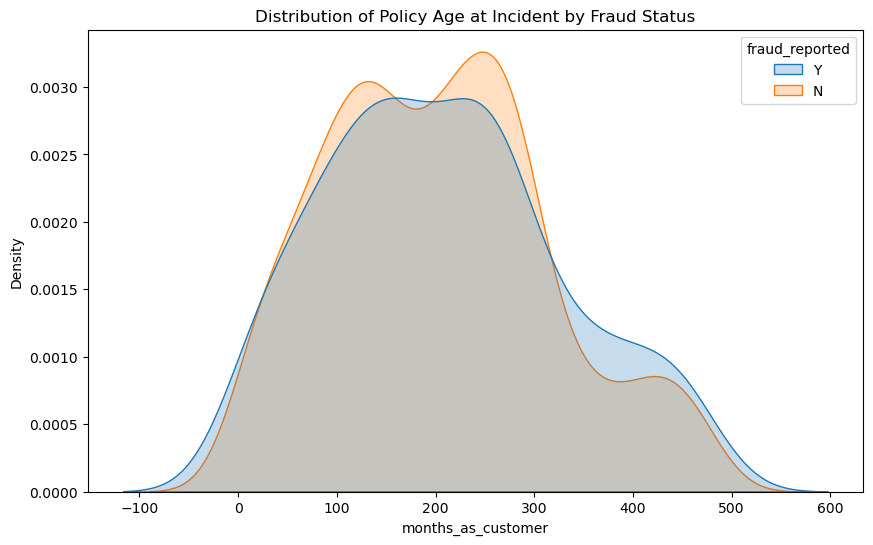

In [32]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='months_as_customer', hue='fraud_reported', fill=True, common_norm=False)
plt.title('Distribution of Policy Age at Incident by Fraud Status')
plt.show()

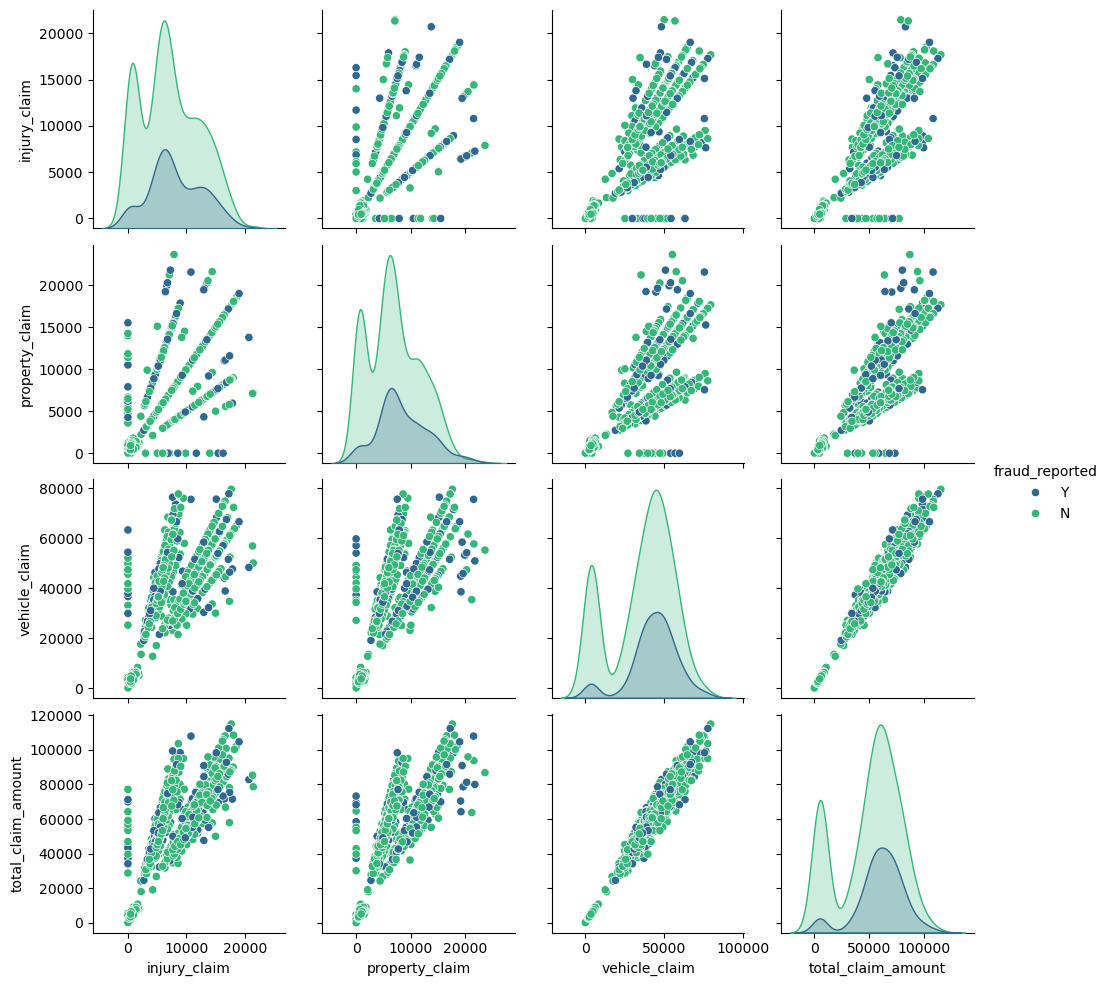

In [33]:
# Select a subset of columns for the pairplot
pairplot_cols = ['injury_claim', 'property_claim', 'vehicle_claim', 'total_claim_amount', 'fraud_reported']

sns.pairplot(df[pairplot_cols], hue='fraud_reported', palette='viridis')
plt.show()

In [34]:
df.describe()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,...,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,claim_premium_ratio
count,1000.000000,1000.000000,1000.000000,1000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,2002-02-08 04:40:47.999999872,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,...,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,43.771088
min,0.000000,19.000000,100804.000000,1990-01-08 00:00:00,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,...,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,0.067452
25%,115.750000,32.000000,335980.250000,1995-09-19 00:00:00,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,...,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,32.353492
50%,199.500000,38.000000,533135.000000,2002-04-01 12:00:00,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,...,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,44.975200
75%,276.250000,44.000000,759099.750000,2008-04-21 12:00:00,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,...,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,58.689165
max,479.000000,64.000000,999435.000000,2015-02-22 00:00:00,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,...,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,157.988148
std,115.113174,9.140287,257063.005276,NaN,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,...,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,24.641878


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          1000 non-null   int64         
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            1000 non-null   int64         
 7   policy_annual_premium        1000 non-null   float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      1000 non-null  

In [36]:
df['number_of_vehicles_involved'].unique()


array([1, 3, 4, 2], dtype=int64)

# Model Building

💡 Important Columns to Keep (Feature Selection)

In [39]:
# List of important features and the target variable
selected_columns = [
    # Claim & Incident Details
    'total_claim_amount',
    'incident_severity',
    'incident_type',
    'collision_type',
    'property_damage',
    'bodily_injuries',
    
    # Policy & Customer Information
    'months_as_customer',
    'policy_annual_premium',
    'policy_deductable',
    'umbrella_limit',
    
    # Insured's Profile
    'insured_occupation',
    'insured_relationship',
    'age',
    'insured_sex',
    'insured_education_level',
    
    # Incident Context
    'authorities_contacted',
    'witnesses',
    'police_report_available',
    
    # The Target Variable
    'fraud_reported'
]

# Create the new DataFrame with only the selected columns
df_model= df[selected_columns]



In [40]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_claim_amount       1000 non-null   int64  
 1   incident_severity        1000 non-null   object 
 2   incident_type            1000 non-null   object 
 3   collision_type           1000 non-null   object 
 4   property_damage          1000 non-null   object 
 5   bodily_injuries          1000 non-null   int64  
 6   months_as_customer       1000 non-null   int64  
 7   policy_annual_premium    1000 non-null   float64
 8   policy_deductable        1000 non-null   int64  
 9   umbrella_limit           1000 non-null   int64  
 10  insured_occupation       1000 non-null   object 
 11  insured_relationship     1000 non-null   object 
 12  age                      1000 non-null   int64  
 13  insured_sex              1000 non-null   object 
 14  insured_education_level  

In [41]:

scale = MinMaxScaler()

# Only numeric columns
for col in df_model.select_dtypes(include=['int64', 'float64']).columns:
    df_model[[col]] = scale.fit_transform(df_model[[col]])
df_model

C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\783148433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[[col]] = scale.fit_transform(df_model[[col]])
C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\783148433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[[col]] = scale.fit_transform(df_model[[col]])
C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\783148433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,total_claim_amount,incident_severity,incident_type,collision_type,property_damage,bodily_injuries,months_as_customer,policy_annual_premium,policy_deductable,umbrella_limit,insured_occupation,insured_relationship,age,insured_sex,insured_education_level,authorities_contacted,witnesses,police_report_available,fraud_reported
0,0.622801,Major Damage,Single Vehicle Collision,Side Collision,YES,0.5,0.684760,0.603112,0.333333,0.090909,craft-repair,husband,0.644444,MALE,MD,Police,0.666667,YES,Y
1,0.043285,Minor Damage,Vehicle Theft,Unknown,Unknown,0.0,0.475992,0.473214,1.000000,0.545455,machine-op-inspct,other-relative,0.511111,MALE,MD,Police,0.000000,Unknown,Y
2,0.300906,Minor Damage,Multi-vehicle Collision,Rear Collision,NO,1.0,0.279749,0.606972,1.000000,0.545455,sales,own-child,0.222222,FEMALE,PhD,Police,1.000000,NO,N
3,0.551298,Major Damage,Single Vehicle Collision,Front Collision,Unknown,0.5,0.534447,0.608582,1.000000,0.636364,armed-forces,unmarried,0.488889,FEMALE,PhD,Police,0.666667,NO,Y
4,0.055739,Minor Damage,Vehicle Theft,Unknown,NO,0.0,0.475992,0.712760,0.333333,0.636364,sales,unmarried,0.555556,MALE,Associate,unknown,0.333333,NO,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.758579,Minor Damage,Single Vehicle Collision,Front Collision,YES,0.0,0.006263,0.543574,0.333333,0.090909,craft-repair,unmarried,0.422222,FEMALE,Masters,Fire,0.333333,Unknown,N
996,0.943912,Major Damage,Single Vehicle Collision,Rear Collision,YES,1.0,0.594990,0.621622,0.333333,0.090909,prof-specialty,wife,0.488889,FEMALE,PhD,Fire,1.000000,Unknown,N
997,0.587006,Minor Damage,Multi-vehicle Collision,Side Collision,Unknown,1.0,0.271399,0.588604,0.000000,0.363636,armed-forces,other-relative,0.333333,FEMALE,Masters,Police,1.000000,YES,N
998,0.408291,Major Damage,Single Vehicle Collision,Rear Collision,Unknown,0.0,0.956159,0.572145,1.000000,0.545455,handlers-cleaners,wife,0.955556,MALE,Associate,Other,0.333333,YES,N


In [42]:
for col in df_model.select_dtypes(include='object').columns:
    print(f"{col}:\n", df_model[col].value_counts().index.tolist())
    print("-" * 40)


incident_severity:
 ['Minor Damage', 'Total Loss', 'Major Damage', 'Trivial Damage']
----------------------------------------
incident_type:
 ['Multi-vehicle Collision', 'Single Vehicle Collision', 'Vehicle Theft', 'Parked Car']
----------------------------------------
collision_type:
 ['Rear Collision', 'Side Collision', 'Front Collision', 'Unknown']
----------------------------------------
property_damage:
 ['Unknown', 'NO', 'YES']
----------------------------------------
insured_occupation:
 ['machine-op-inspct', 'prof-specialty', 'tech-support', 'sales', 'exec-managerial', 'craft-repair', 'transport-moving', 'other-service', 'priv-house-serv', 'armed-forces', 'adm-clerical', 'protective-serv', 'handlers-cleaners', 'farming-fishing']
----------------------------------------
insured_relationship:
 ['own-child', 'other-relative', 'not-in-family', 'husband', 'wife', 'unmarried']
----------------------------------------
insured_sex:
 ['FEMALE', 'MALE']
----------------------------------

In [43]:
le = LabelEncoder()

for i in df_model.select_dtypes(include='object').columns:
    df_model[i] = le.fit_transform(df_model[i])


C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\2651476132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[i] = le.fit_transform(df_model[i])
C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\2651476132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[i] = le.fit_transform(df_model[i])
C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\2651476132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [44]:
df_model

,total_claim_amount,incident_severity,incident_type,collision_type,property_damage,bodily_injuries,months_as_customer,policy_annual_premium,policy_deductable,umbrella_limit,insured_occupation,insured_relationship,age,insured_sex,insured_education_level,authorities_contacted,witnesses,police_report_available,fraud_reported
0,0.622801,0,2,2,2,0.5,0.684760,0.603112,0.333333,0.090909,2,0,0.644444,1,4,3,0.666667,2,1
1,0.043285,1,3,3,1,0.0,0.475992,0.473214,1.000000,0.545455,6,2,0.511111,1,4,3,0.000000,1,1
2,0.300906,1,0,1,0,1.0,0.279749,0.606972,1.000000,0.545455,11,3,0.222222,0,6,3,1.000000,0,0
3,0.551298,0,2,0,1,0.5,0.534447,0.608582,1.000000,0.636364,1,4,0.488889,0,6,3,0.666667,0,1
4,0.055739,1,3,3,0,0.0,0.475992,0.712760,0.333333,0.636364,11,4,0.555556,1,0,4,0.333333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.758579,1,2,0,2,0.0,0.006263,0.543574,0.333333,0.090909,2,4,0.422222,0,5,1,0.333333,1,0
996,0.943912,0,2,1,2,1.0,0.594990,0.621622,0.333333,0.090909,9,5,0.488889,0,6,1,1.000000,1,0
997,0.587006,1,0,2,1,1.0,0.271399,0.588604,0.000000,0.363636,1,2,0.333333,0,5,3,1.000000,2,0
998,0.408291,0,2,1,1,0.0,0.956159,0.572145,1.000000,0.545455,5,5,0.955556,1,0,2,0.333333,2,0


In [45]:
X= df_model.drop('fraud_reported', axis=1)
y= df_model.fraud_reported

In [46]:
X

,total_claim_amount,incident_severity,incident_type,collision_type,property_damage,bodily_injuries,months_as_customer,policy_annual_premium,policy_deductable,umbrella_limit,insured_occupation,insured_relationship,age,insured_sex,insured_education_level,authorities_contacted,witnesses,police_report_available
0,0.622801,0,2,2,2,0.5,0.684760,0.603112,0.333333,0.090909,2,0,0.644444,1,4,3,0.666667,2
1,0.043285,1,3,3,1,0.0,0.475992,0.473214,1.000000,0.545455,6,2,0.511111,1,4,3,0.000000,1
2,0.300906,1,0,1,0,1.0,0.279749,0.606972,1.000000,0.545455,11,3,0.222222,0,6,3,1.000000,0
3,0.551298,0,2,0,1,0.5,0.534447,0.608582,1.000000,0.636364,1,4,0.488889,0,6,3,0.666667,0
4,0.055739,1,3,3,0,0.0,0.475992,0.712760,0.333333,0.636364,11,4,0.555556,1,0,4,0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.758579,1,2,0,2,0.0,0.006263,0.543574,0.333333,0.090909,2,4,0.422222,0,5,1,0.333333,1
996,0.943912,0,2,1,2,1.0,0.594990,0.621622,0.333333,0.090909,9,5,0.488889,0,6,1,1.000000,1
997,0.587006,1,0,2,1,1.0,0.271399,0.588604,0.000000,0.363636,1,2,0.333333,0,5,3,1.000000,2
998,0.408291,0,2,1,1,0.0,0.956159,0.572145,1.000000,0.545455,5,5,0.955556,1,0,2,0.333333,2


In [47]:
X_train,X_test, y_train,y_test=train_test_split(X,y, test_size=.2,random_state=42)

In [48]:
## The model learns to favor the majority class (0) to get higher accuracy.
## so we apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [49]:
# Apply SMOTE only to the training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [50]:
# Model building

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [51]:
y_pred_train_rf = model_rf.predict(X_train_resampled)
y_pred_test_rf = model_rf.predict(X_test)




In [52]:

print("Train Accuracy:", accuracy_score(y_train_resampled, y_pred_train_rf))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("ROC AUC:", roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))
print("Classification Report:\n", classification_report(y_test, y_pred_test_rf))


Train Accuracy: 1.0
Test Accuracy: 0.745
ROC AUC: 0.7158620689655173
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       145
           1       0.54      0.47      0.50        55

    accuracy                           0.74       200
   macro avg       0.68      0.66      0.67       200
weighted avg       0.74      0.74      0.74       200



In [53]:

# Confusion matrix for Random Forest predictions
conf_matrix = confusion_matrix(y_test, y_pred_test_rf)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[123  22]
 [ 29  26]]


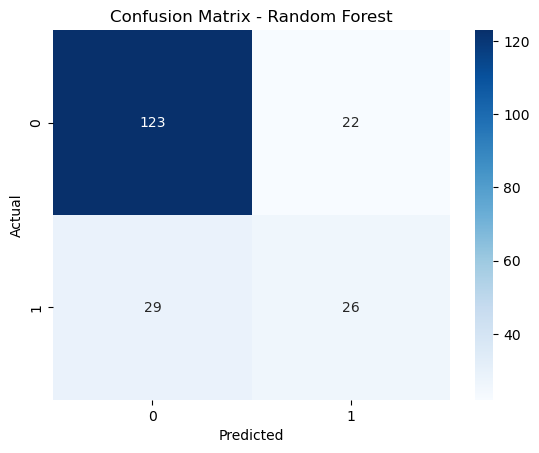

In [54]:


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


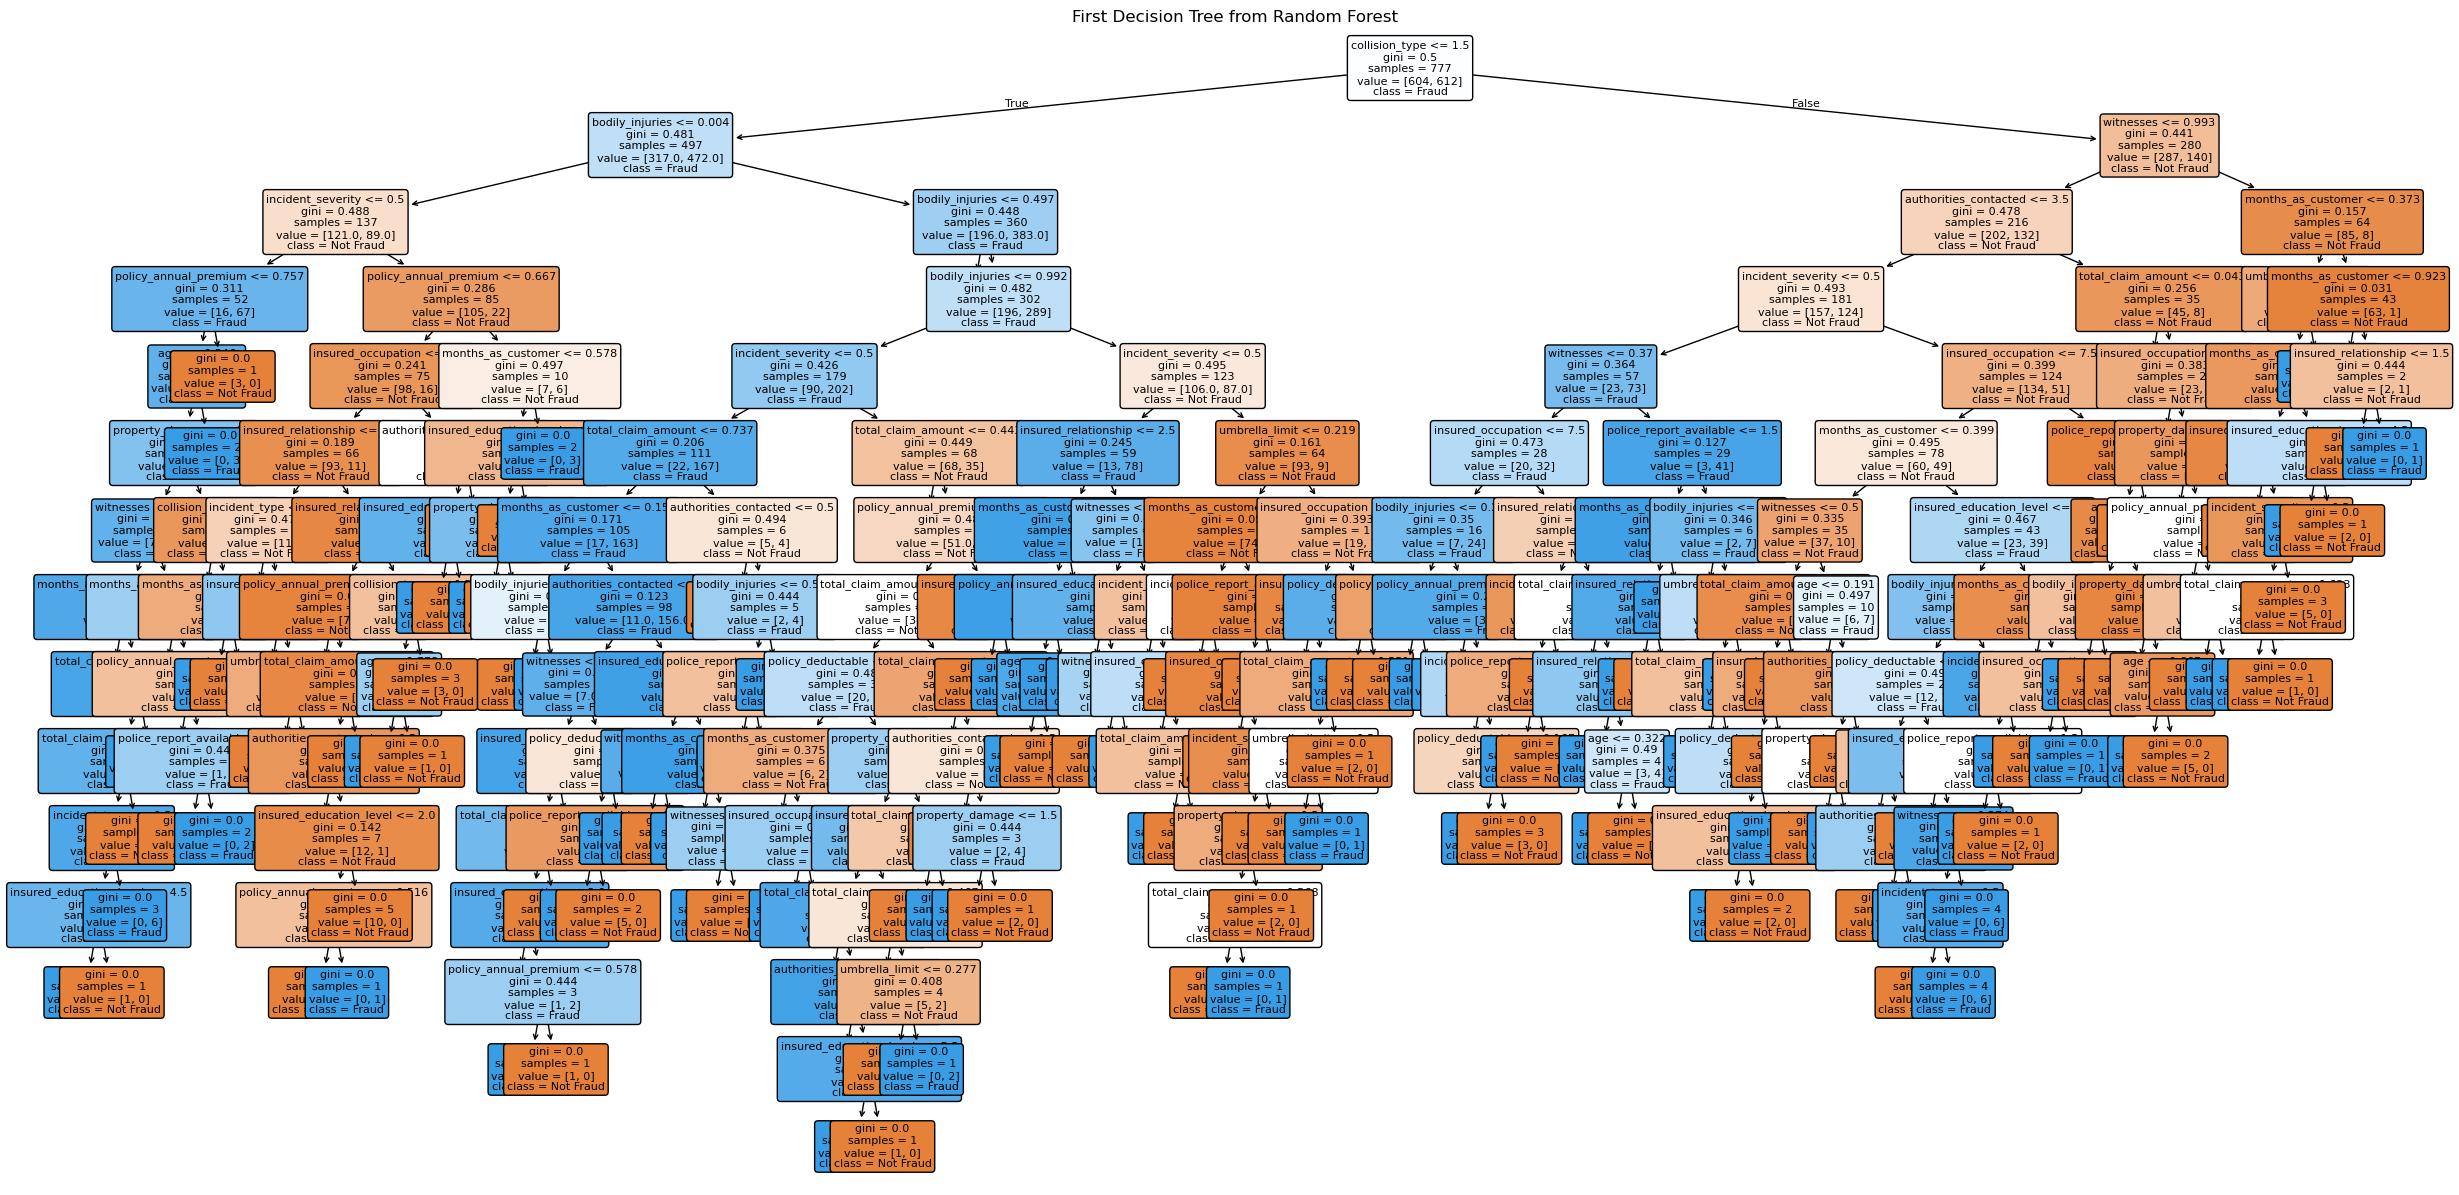

In [55]:


# Plot the first tree from the random forest
plt.figure(figsize=(30, 15))
plot_tree(model_rf.estimators_[0], 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Not Fraud', 'Fraud'], 
          rounded=True,
          fontsize=8)
plt.title("First Decision Tree from Random Forest")
plt.show()


In [56]:


# Model setup
model_1 = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=10, 
    min_samples_split=4, 
    min_samples_leaf=3,
    random_state=42
)

# Train on SMOTE-balanced data
model_1.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_train = model_1.predict(X_train_resampled)
y_pred_test = model_1.predict(X_test)

# Evaluate
print("Train Accuracy:", accuracy_score(y_train_resampled, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))


Train Accuracy: 0.9366776315789473
Test Accuracy: 0.625


In [57]:


# Initialize the model
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit to SMOTE-balanced training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Final model
best_dt = grid_search.best_estimator_

# Evaluate on actual test set


y_pred_test = best_dt.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Accuracy: 0.8109458274303446
Test Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       145
           1       0.59      0.65      0.62        55

    accuracy                           0.78       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.79      0.78      0.78       200



In [58]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.8109458274303446


In [59]:
# Use best estimator from grid search
best_dt = grid_search.best_estimator_

# Predict on test and train sets
y_pred_test = best_dt.predict(X_test)
y_pred_train = best_dt.predict(X_train_resampled)



print("Train Accuracy for :", accuracy_score(y_train_resampled, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))


Train Accuracy for : 0.828125
Test Accuracy: 0.78

Confusion Matrix:
 [[120  25]
 [ 19  36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       145
           1       0.59      0.65      0.62        55

    accuracy                           0.78       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.79      0.78      0.78       200



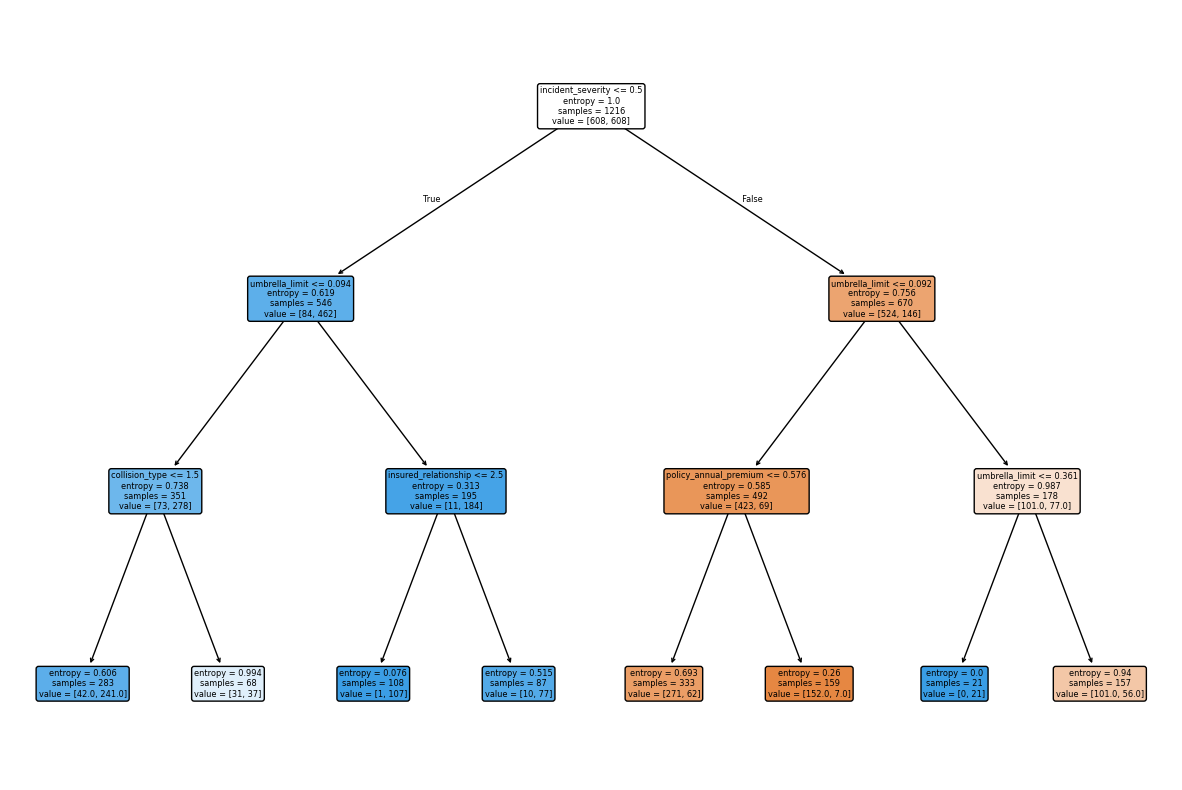

In [60]:


plt.figure(figsize=(15, 10))
plot_tree(best_dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()


## Trying other models as well 

In [62]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf_test = model_rf.predict(X_test)
y_pred_rf_train = model_rf.predict(X_train_resampled)

print("Random Forest - Test Accuracy:", accuracy_score(y_test, y_pred_rf_test))
print("Random Forest - Train Accuracy:", accuracy_score(y_train_resampled, y_pred_rf_train))

Random Forest - Test Accuracy: 0.745
Random Forest - Train Accuracy: 1.0


In [63]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train_resampled, y_train_resampled)

y_pred_xgb_test = model_xgb.predict(X_test)
y_pred_xgb_train = model_xgb.predict(X_train_resampled)

print("XGBoost - Test Accuracy:", accuracy_score(y_test, y_pred_xgb_test))
print("XGBoost - Train Accuracy:", accuracy_score(y_train_resampled, y_pred_xgb_train))


XGBoost - Test Accuracy: 0.715
XGBoost - Train Accuracy: 1.0


C:\Users\pankk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:52:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [64]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_resampled, y_train_resampled)

y_pred_lr_test = model_lr.predict(X_test)
y_pred_lr_train = model_lr.predict(X_train_resampled)

print("LogReg - Test Accuracy:", accuracy_score(y_test, y_pred_lr_test))
print("LogReg - Train Accuracy:", accuracy_score(y_train_resampled, y_pred_lr_train))


LogReg - Test Accuracy: 0.715
LogReg - Train Accuracy: 0.8050986842105263


In [65]:
#Now that we now that Decision Tree (optimized) is currently best model based on test performance.

In [66]:
#let’s stack the top 3 (Decision Tree, Random Forest, and Logistic Regression) to see if we can boost test performance:

In [67]:


estimators = [
    ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=1, min_samples_split=2)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacked_model.fit(X_train_resampled, y_train_resampled)

y_pred_stack_test = stacked_model.predict(X_test)
y_pred_stack_train = stacked_model.predict(X_train_resampled)

print("Stacked Model - Test Accuracy:", accuracy_score(y_test, y_pred_stack_test))
print("Stacked Model - Train Accuracy:", accuracy_score(y_train_resampled, y_pred_stack_train))


Stacked Model - Test Accuracy: 0.745
Stacked Model - Train Accuracy: 1.0


In [68]:
# That proves that the decision tree ia working best for us 

In [69]:
# Retriving the pkl file model deployment 

filename = 'D:\Capstone Project/finalized_model.pkl'
pickle.dump(best_dt, open(filename, 'wb'))

<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
C:\Users\pankk\AppData\Local\Temp\ipykernel_19216\198982648.py:3: SyntaxWarning: invalid escape sequence '\C'
  filename = 'D:\Capstone Project/finalized_model.pkl'


In [70]:
X.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_claim_amount       1000 non-null   float64
 1   incident_severity        1000 non-null   int32  
 2   incident_type            1000 non-null   int32  
 3   collision_type           1000 non-null   int32  
 4   property_damage          1000 non-null   int32  
 5   bodily_injuries          1000 non-null   float64
 6   months_as_customer       1000 non-null   float64
 7   policy_annual_premium    1000 non-null   float64
 8   policy_deductable        1000 non-null   float64
 9   umbrella_limit           1000 non-null   float64
 10  insured_occupation       1000 non-null   int32  
 11  insured_relationship     1000 non-null   int32  
 12  age                      1000 non-null   float64
 13  insured_sex              1000 non-null   int32  
 14  insured_education_level  

In [71]:
y.info()


<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: fraud_reported
Non-Null Count  Dtype
--------------  -----
1000 non-null   int32
dtypes: int32(1)
memory usage: 4.0 KB
